# Functions definition

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# GRAPH GENERATION
def create_strongly_connected_directed_graph(N, extra_edges=5):
    G = nx.DiGraph()
    # Add nodes
    G.add_nodes_from(range(N))
    # Create a directed ring
    for i in range(N):
        G.add_edge(i, (i + 1) % N)
    # Randomly add more edges to ensure strong connectivity
    while not nx.is_strongly_connected(G):
        u, v = np.random.randint(0, N), np.random.randint(0, N)
        if u != v:
            G.add_edge(u, v)
    # Add extra edges
    for _ in range(extra_edges):
        u, v = np.random.randint(0, N), np.random.randint(0, N)
        if u != v:
            G.add_edge(u, v)
    A = nx.adjacency_matrix(G).toarray()
    return A
    
# PROTOCOLS 
def standard_protocol(L, x, kappa, g):
    N = L.shape[0]
    I = np.eye(N)
    u = -kappa * L @ x
    return u
    
def centralized_protocol(L, x, kappa, g):
    N = L.shape[0]
    I = np.eye(N)
    W = np.linalg.inv(I + kappa * g * L)
    u = -kappa * W @ L @ x
    return u

def distributed_protocol(L, A, x, kappa, g, gamma):
    N = L.shape[0]
    u = np.zeros(N)
    di = np.sum(A, axis=1)
    
    # Step 1: Send x_i(t) to the neighbors (implied in calculation)
    # Step 2: Receive x_j(t) from the neighbors and compute v_i(t, 0)
    v = np.zeros((N, gamma + 1))
    for i in range(N):
        neighbors = np.where(A[i] > 0)[0]
        v[i, 0] = -kappa / (1 + g * kappa * di[i]) * sum(x[i] - x[j] for j in neighbors)
    
    # Step 3: Iteratively update v_i(t, h)
    for h in range(gamma):
        for i in range(N):
            neighbors = np.where(A[i] > 0)[0]
            v[i, h + 1] = v[i, 0] + g * kappa / (1 + g * kappa * di[i]) * sum(v[j, h] for j in neighbors)
    
    # Step 4: Set u_i(t) = v_i(t, gamma)
    u = v[:, gamma]
    return u

def simulate_network(N, T, protocol, L, A, kappa, g, gamma=None):
    x = np.random.rand(N)
    x_trajectory = np.zeros((T, N))
    
    for t in range(T):
        if protocol == 'standard':
            u = standard_protocol(L, x, kappa, g)
        elif protocol == 'centralized':
            u = centralized_protocol(L, x, kappa, g)
        elif protocol == 'distributed':
            u = distributed_protocol(L, A, x, kappa, g, gamma)
        x = x + u
        x_trajectory[t, :] = x
    return x, x_trajectory

# PLOTTING FUNCTIONS
def plot_convergence(x_trajectory, protocol_name):
    plt.figure(figsize=(10, 4))
    for i in range(x_trajectory.shape[1]):
        plt.plot(x_trajectory[:, i])
    plt.title(f'States Evolution ({protocol_name} Protocol)')
    plt.xlabel('Time Steps')
    plt.ylabel('State Value')
    plt.grid()
    plt.savefig(f'fig/{protocol_name}.png')
    plt.show()
    
def plot_comparison(trajectories, protocol_name, param_name, params):
    num_trajectories = len(trajectories)
    plt.figure(figsize=(10, 3 * num_trajectories))
    
    for i, (x_trajectory, param) in enumerate(zip(trajectories, params)):
        plt.subplot(num_trajectories, 1, i + 1)
        for j in range(x_trajectory.shape[1]):
            plt.plot(x_trajectory[:, j])
        plt.title(f'States Evolution ({protocol_name} Protocol with {param_name}={param})')
        plt.xlabel('Time Steps')
        plt.ylabel('State Value')
        plt.grid()
    plt.tight_layout()
    plt.savefig(f'fig/{protocol_name}.png')
    plt.show()

def plot_network(A):
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', arrows=True)
    plt.title('Network Graph')
    plt.savefig('fig/Simulation_graph.png')
    plt.show()

def plot_eigenvalues(eigenvalues):
    lambda_max = eigenvalues[np.argmax(np.abs(eigenvalues))]  # Find the eigenvalue with the maximum magnitude
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvalues.real, eigenvalues.imag, 'o', markersize=10)
    plt.plot(lambda_max.real, lambda_max.imag, 'ro', markersize=12,label=f'$\lambda_{{max}}={lambda_max:.4f}$')
    plt.xlabel('Real Part',fontsize=12)
    plt.ylabel('Imaginary Part',fontsize=12)
    plt.grid()
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.legend(fontsize=18)
    plt.savefig('fig/Spectrum_L.png')
    plt.show()

# Graph matrices generation

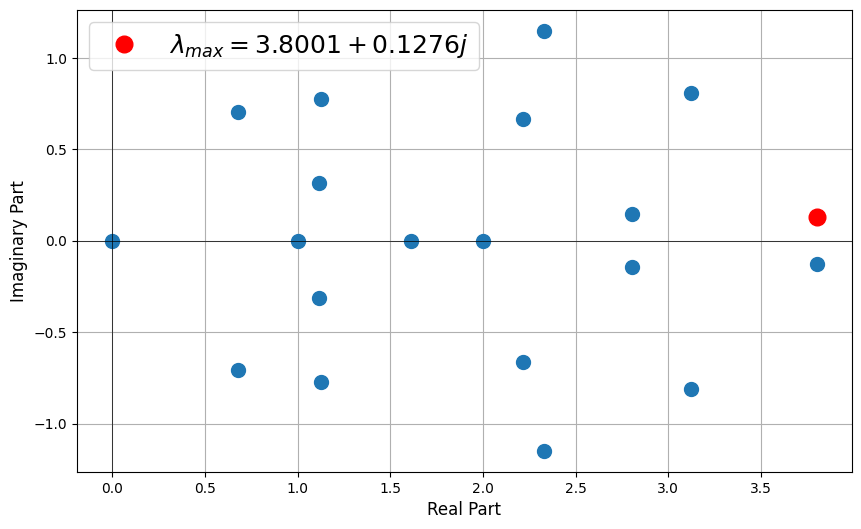

spectrum of L:
(3.8001295511124944+0.1276335584606121j)
(3.8001295511124944-0.1276335584606121j)
(3.1203360667955193+0.8100362523016332j)
(3.1203360667955193-0.8100362523016332j)
(2.3269782258093317+1.148563164425395j)
(2.3269782258093317-1.148563164425395j)
(2.802429349040062+0.14446952318460707j)
(2.802429349040062-0.14446952318460707j)
(7.118143584387281e-16+0j)
(2.2187972778948524+0.6642737886015306j)
(2.2187972778948524-0.6642737886015306j)
(0.6797343751755703+0.7057315761476901j)
(0.6797343751755703-0.7057315761476901j)
(1.1279384782319357+0.7753532923554852j)
(1.1279384782319357-0.7753532923554852j)
(0.9999999999999976+0j)
(1.1179729536843999+0.31364604179314315j)
(1.1179729536843999-0.31364604179314315j)
(1.6113674445116684+0j)
(1.9999999999999984+0j)
lambda max: 3.8022723377585366


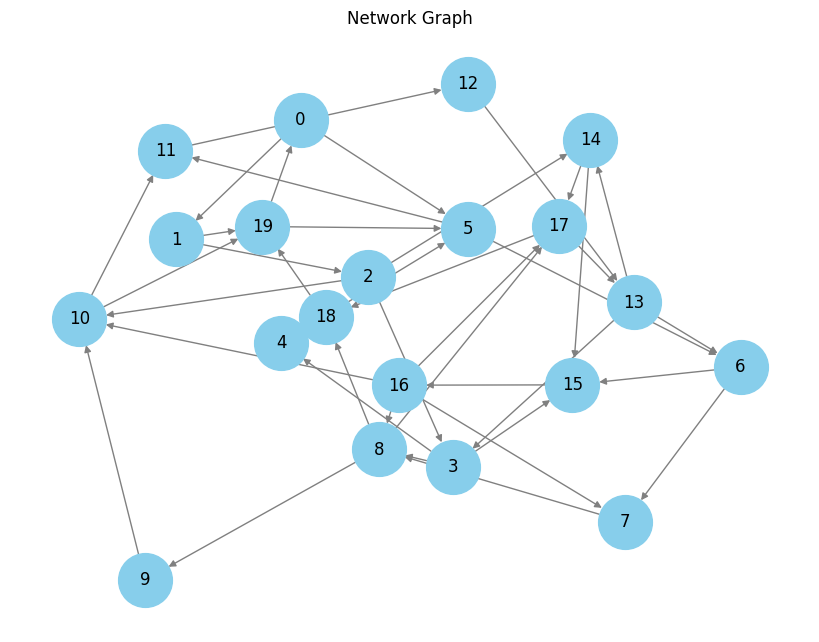

In [36]:
N = 20 # Number of agents
np.random.seed(1896877)
A = create_strongly_connected_directed_graph(N, extra_edges=20) # Adj matrix
D = np.diag(np.sum(A, axis=1))  # Degree matrix
L = D - A # Laplatian Matrix
sigma_L = np.linalg.eigvals(L)
plot_eigenvalues(sigma_L)
lambda_max = np.abs(np.max(sigma_L))
print('spectrum of L:')
for i in sigma_L:
    print(i)
print(f'lambda max: {lambda_max}')
plot_network(A)

# Simulations

Standard Protocol

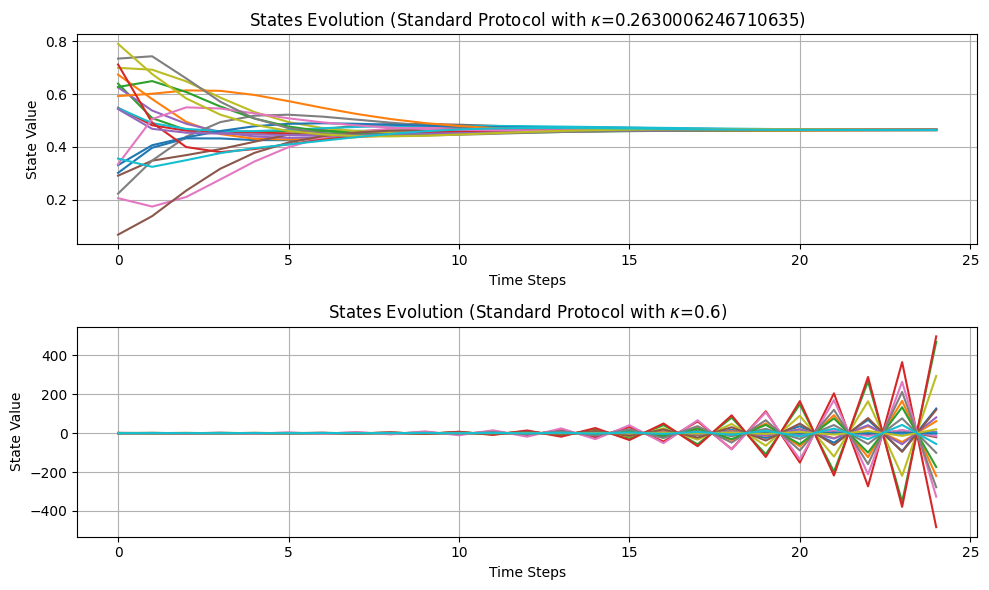

Final states (Standard): [0.46395715 0.464182   0.46439929 0.46481229 0.46379067 0.46389784
 0.46555767 0.46589719 0.46495643 0.46413207 0.46315347 0.46322811
 0.46456172 0.46521347 0.46514573 0.46508623 0.46492298 0.46512449
 0.46449815 0.46373537]
Final states (Standard): [ 126.95064863 -219.99650569  470.07688825 -483.75009402    7.18649805
  -20.74843357  -14.91559269 -101.04032036  294.0310296     1.76399224
   -2.65337827   61.7460166  -174.1703091   498.17118994   81.26088006
  120.39234269 -326.83659263 -278.35653853   19.95265445  -55.46236145]


In [46]:
# Calculate lambda_max (maximum eigenvalue of L)

kappa_standard_1 =  (1 / lambda_max)
kappa_standard_2 =  0.6#0.2+(1 / lambda_max)
g_standard = 1  # Parameter g for standard protocol (1 such that it is ininfluent)

# Simulate using the standard protocol
x_final_standard_1, x_trajectory_standard_1 = simulate_network(
    N,\
    T+10,\
    'standard',\
    L,\
    A,\
    kappa_standard_1,\
    g_standard
)
x_final_standard_2, x_trajectory_standard_2 = simulate_network(
    N,\
    T+10,\
    'standard',\
    L,\
    A,\
    kappa_standard_2,\
    g_standard
)
# Plot the convergence for the centralized protocol
#plot_convergence(x_trajectory_standard, 'Standard')
trajectories = [
    x_trajectory_standard_1,\
    x_trajectory_standard_2
]
params = [kappa_standard_1,kappa_standard_2]
plot_comparison(trajectories, 'Standard', '$\kappa$',params)

# Print final states
print("Final states (Standard):", x_final_standard_1)
print("Final states (Standard):", x_final_standard_2)

Centralized Protocol

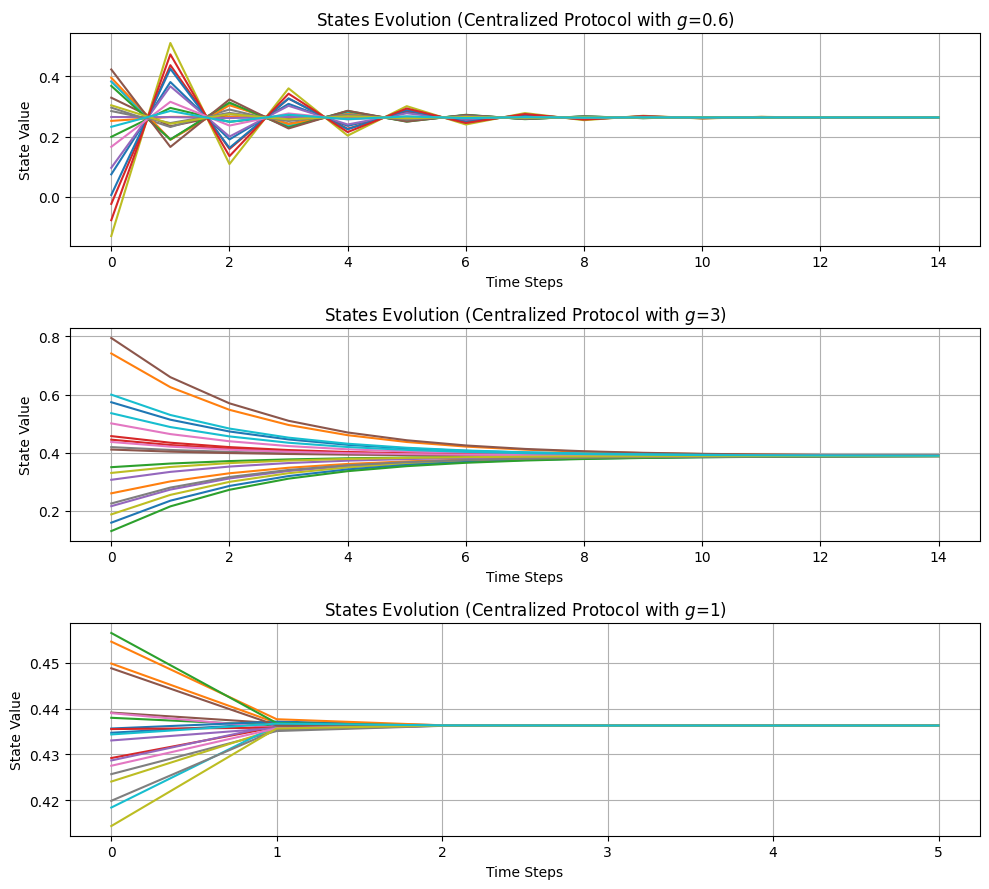

Final states (Centralized): [0.26326982 0.26356792 0.2636329  0.26326043 0.26338398 0.26330629
 0.26344413 0.26366891 0.26291366 0.26365411 0.26319473 0.26340876
 0.26366456 0.26306595 0.26336716 0.26356352 0.26356027 0.26363767
 0.26351558 0.26347972]
Final states (Centralized): [0.38978487 0.39035945 0.38888361 0.38928032 0.38841252 0.39046343
 0.38946759 0.38917241 0.38836724 0.38978266 0.38819012 0.38846171
 0.38807402 0.3892569  0.38876064 0.38912945 0.38920965 0.38850222
 0.38892371 0.38964788]
Final states (Centralized): [0.43629086 0.43629086 0.43629086 0.43629086 0.43629086 0.43629086
 0.43629087 0.43629087 0.43629087 0.43629087 0.43629086 0.43629085
 0.43629086 0.43629086 0.43629086 0.43629087 0.43629086 0.43629086
 0.43629086 0.43629086]


In [47]:
# Calculate lambda_max (maximum eigenvalue of L)
kappa_centralized =  20 # can be big as we want
g_1 = 0.6  # Parameter g for centralized protocol (1 such that it is ininfluent)
g_2 = 3
g_3 = 1
# Simulate using the centralized protocol
x_final_centralized_1, x_trajectory_centralized_1 = simulate_network(
    N,\
    15,\
    'centralized',\
    L,\
    A,\
    kappa_centralized,\
    g_1
)
x_final_centralized_2, x_trajectory_centralized_2 = simulate_network(
    N,\
    15,\
    'centralized',\
    L,\
    A,\
    kappa_centralized,\
    g_2
)
x_final_centralized_3, x_trajectory_centralized_3 = simulate_network(
    N,\
    6,\
    'centralized',\
    L,\
    A,\
    kappa_centralized,\
    g_3
)
trajectories = [
    x_trajectory_centralized_1,\
    x_trajectory_centralized_2,\
    x_trajectory_centralized_3
]
params = [g_1,g_2,g_3]
# Plot the convergence for the centralized protocol
#plot_convergence(x_trajectory_centralized, 'Centralized')
plot_comparison(trajectories, 'Centralized', '$g$',params)

# Print final states
print("Final states (Centralized):", x_final_centralized_1)
print("Final states (Centralized):", x_final_centralized_2)
print("Final states (Centralized):", x_final_centralized_3)

Distributed Protocol

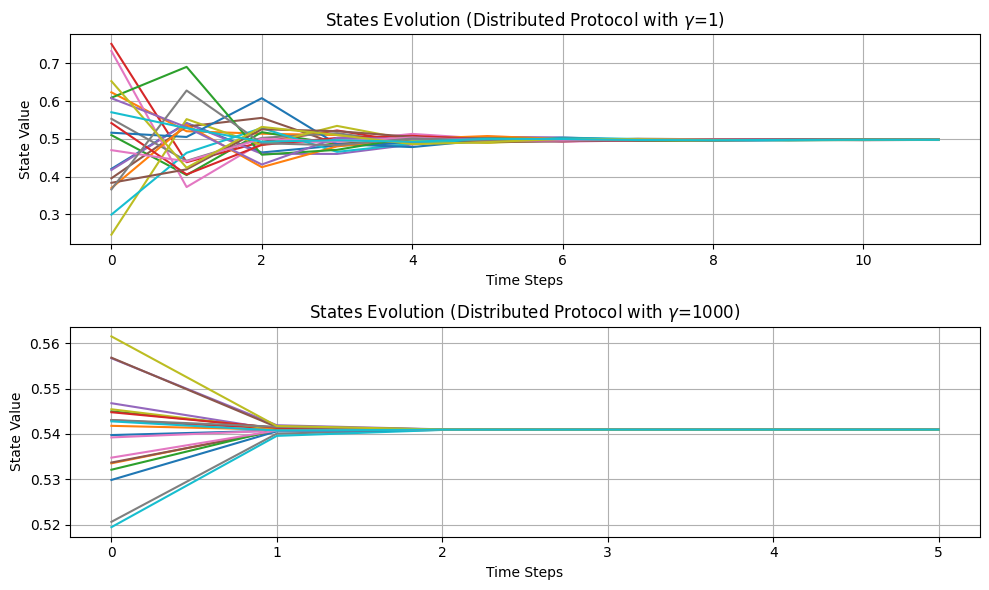

Final states (Distributed): [0.49740133 0.49739781 0.49733011 0.49728344 0.49742599 0.49716007
 0.49696674 0.49727506 0.49744252 0.49773017 0.49754433 0.49722241
 0.49705952 0.49699181 0.4970974  0.49712744 0.49730258 0.49727514
 0.49749356 0.49739283]
Final states (Distributed): [0.54096484 0.54096484 0.54096484 0.54096483 0.54096483 0.54096483
 0.54096483 0.54096483 0.54096483 0.54096483 0.54096484 0.54096484
 0.54096483 0.54096483 0.54096484 0.54096483 0.54096483 0.54096484
 0.54096484 0.54096483]


In [48]:
kappa = 20  # Coupling strength for distributed protocol
g_distributed = 1  # Parameter g for distributed protocol (should be >= 0.5)
gamma_1 = 1  # Number of iterations for distributed protocol
gamma_2=1000
# Simulate using the distributed protocol
x_final_distributed_1, x_trajectory_distributed_1 = simulate_network(
    N,\
    12,\
    'distributed',\
    L,\
    A,\
    kappa,\
    g_distributed,\
    gamma_1
)
x_final_distributed_2, x_trajectory_distributed_2 = simulate_network(
    N,\
    6,\
    'distributed',\
    L,\
    A,\
    kappa,\
    g_distributed,\
    gamma_2
)
trajectories = [x_trajectory_distributed_1,x_trajectory_distributed_2]
params = [gamma_1, gamma_2]
# Plot the convergence for the distributed protocol
plot_comparison(trajectories, 'Distributed', '$\gamma$',params)
print("Final states (Distributed):", x_final_distributed_1)
print("Final states (Distributed):", x_final_distributed_2)